In [1]:
## Import libraries
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "../source"
sys.path.append(source)

from preprocessing import Encoding
from compilation import Compiler, ScalarTracker, ActivationTracker
import publication
import simulate
import models

device = torch.device("cpu")

save = True

In [2]:
## Load settings
settings = "default"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)

if nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [3]:
## Generate data
input_dim, output_dim = in_dim, out_dim

inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
    input_dim
)
outputs = np.array([[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]) / np.sqrt(
    output_dim
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]
val_dataset = [data]

tracked_datasets = val_dataset + train_datasets

In [4]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=input_dim,
    output_size=output_dim,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=nonlinearity,
)

In [5]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=tracked_datasets
    ),
}
for l in range(L):
    compiler.trackers[f"hidden_{l}"] = ActivationTracker(
        model, lambda inputs, l=l: model(inputs)[1][l], datasets=tracked_datasets
    )

In [6]:
## Training run
compiler.training_run(
    train_datasets,
    n_epochs=n_epochs,
    batch_size=100,
)

Training: 100%|██████████| 3000/3000 [04:24<00:00, 11.32steps/s, train_loss=0.00000, val_loss=0.00000]


In [7]:
## Get data
data_output = compiler.trackers["output"].get_trace()
epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()
y_A = [
    np.array(data.loc[epoch, 0, "A"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_B = [
    np.array(data.loc[epoch, 0, "B"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_true_A, y_true_B = outputs[0], outputs[1]
dy2 = np.sum((y_true_B - y_true_A) ** 2)
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)

In [8]:
## Fit effective learning rates and plot results
eta_hs, eta_ys, losses = [], [], []
for l in trange(L):
    data_hid = compiler.trackers[f"hidden_{l}"].get_trace()
    epochs = list(set(data_output.index.get_level_values("Epoch")))
    epochs.sort()

    h_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    h_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]

    h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])

    eta_h_opt, eta_y_opt, loss = simulate.optimize_eta(
        h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 100)
    )
    eta_hs.append(eta_h_opt)
    eta_ys.append(eta_y_opt)
    losses.append(loss)

  5%|▌         | 1/20 [00:04<01:20,  4.23s/it]

Loss: 22.120768888516587


 10%|█         | 2/20 [00:11<01:46,  5.89s/it]

Loss: 20.300055688355446


 15%|█▌        | 3/20 [00:19<02:00,  7.07s/it]

Loss: 17.322402784083543


 20%|██        | 4/20 [00:25<01:46,  6.63s/it]

Loss: 13.350044426221622


 25%|██▌       | 5/20 [00:30<01:30,  6.05s/it]

Loss: 9.777187006547372


 30%|███       | 6/20 [00:34<01:12,  5.17s/it]

Loss: 7.701530561493993


 35%|███▌      | 7/20 [00:41<01:17,  5.97s/it]

Loss: 5.056510886349508


 40%|████      | 8/20 [00:48<01:13,  6.15s/it]

Loss: 3.0783108817343843


 45%|████▌     | 9/20 [00:54<01:06,  6.03s/it]

Loss: 1.8474801654157131


 50%|█████     | 10/20 [00:58<00:54,  5.46s/it]

Loss: 0.8573543317121756


 55%|█████▌    | 11/20 [01:02<00:44,  4.95s/it]

Loss: 0.3582200336562439


 60%|██████    | 12/20 [01:09<00:44,  5.58s/it]

Loss: 0.09401725860332216


 65%|██████▌   | 13/20 [01:16<00:42,  6.13s/it]

Loss: 0.10022910816537009


 70%|███████   | 14/20 [01:19<00:30,  5.15s/it]

Loss: 0.23497499836068902


 75%|███████▌  | 15/20 [01:23<00:24,  4.93s/it]

Loss: 0.5229831516523521


 80%|████████  | 16/20 [01:28<00:19,  4.80s/it]

Loss: 0.9207606644442051


 85%|████████▌ | 17/20 [01:32<00:14,  4.70s/it]

Loss: 1.4913575847150184


 90%|█████████ | 18/20 [01:36<00:08,  4.27s/it]

Loss: 3.036353123014333


 95%|█████████▌| 19/20 [01:41<00:04,  4.54s/it]

Loss: 2.060694655737974


100%|██████████| 20/20 [01:47<00:00,  5.36s/it]

Loss: 1.622818304372048


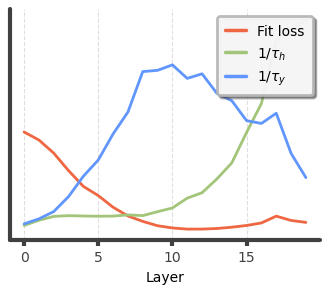

In [9]:
losses, eta_hs, eta_ys = [np.array(a) for a in [losses, eta_hs, eta_ys]]

publication.set_color_mixed(0)
fig = plt.figure(figsize=(4, 3))
publication.skip_colors(6)
plt.plot(0.02 * losses, label="Fit loss")
plt.plot(70 * eta_hs, label=r"$1/\tau_h$")
publication.skip_colors(7)

plt.plot(7 * eta_ys, label=r"$1/\tau_y$")
plt.xlabel("Layer")
legend = plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
if save:
    publication.plt_show(save_path="plots/2_points/architecture/depth")
else:
    publication.plt_show()